In [2]:
from sklearn.metrics.pairwise import polynomial_kernel, rbf_kernel
from scipy.linalg import svd
import numpy as np
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import center_of_mass
from math import sqrt

In [3]:
(images, _), (_, _) = mnist.load_data()
images = images[:10000,]
images.shape

flattened_images = images.reshape(images.shape[0], -1)

In [33]:
def get_distorted_values(source_x, source_y, radius, distortion):
    if 1 - distortion * (radius ** 2) == 0:
        return source_x, source_y

    return source_x / (1 - (distortion * (radius ** 2))), source_y / (1 - (distortion * (radius **2 )))


def fish(image, distortion_coefficient):
    image_width, image_height = float(image.shape[0]), float(image.shape[1])
    new_image = np.zeros_like(image)

    for x in range(len(new_image)):
        for y in range(len(new_image[x])):

            # normalize x and y to be in interval of [-1, 1]
            x_normalized, y_normalized = float((2 * x - image_width) / image_width), float((2 * y - image_height) / image_height)

            radius = sqrt(x_normalized ** 2 + y_normalized ** 2)

            # new normalized pixel coordinates
            x_distorted, y_distorted = get_distorted_values(x_normalized, y_normalized, radius, distortion_coefficient)

            # un-normalize
            x_nonnormalized, y_nonnormalized = int(((x_distorted + 1) * image_width) / 2), int(((y_distorted + 1) * image_height) / 2)

            # if new pixel is in bounds copy from source pixel to destination pixel
            if 0 <= x_nonnormalized and x_nonnormalized < image.shape[0] and 0 <= y_nonnormalized and y_nonnormalized < image.shape[1]:
                new_image[x][y] = image[x_nonnormalized][y_nonnormalized]

    return new_image.astype(np.uint8)

In [36]:
def perform_fisheye_transform(data, distortion):
    new_images = []
    for i in range(data.shape[0]):
        image = images[i, :, :].reshape((28, 28))
        new_images.append(fish(image, distortion))
    return np.array(new_images)

In [65]:
fisheye_0_5 = perform_fisheye_transform(images, 0.5)
flattened_fisheye_0_5 = fisheye_0_5.reshape(fisheye_0_5.shape[0], -1)

fisheye_1 = perform_fisheye_transform(images, 1)
flattened_fisheye_1 = fisheye_1.reshape(fisheye_1.shape[0], -1)

fisheye_5 = perform_fisheye_transform(images, 5)
flattened_fisheye_5 = fisheye_5.reshape(fisheye_5.shape[0], -1)

fisheye_10 = perform_fisheye_transform(images, 10)
flattened_fisheye_10 = fisheye_10.reshape(fisheye_10.shape[0], -1)

fisheye_100 = perform_fisheye_transform(images, 100)
flattened_fisheye_100 = fisheye_10.reshape(fisheye_100.shape[0], -1)

In [74]:
U_orig, E_orig, V_t_orig = np.linalg.svd(flattened_images, full_matrices=False)

U_fish_0_5, E_fish_0_5, V_t_fish_0_5 = np.linalg.svd(flattened_fisheye_0_5, full_matrices=False)
U_fish_1, E_fish_1, V_t_fish_1 = np.linalg.svd(flattened_fisheye_1, full_matrices=False)
U_fish_5, E_fish_5, V_t_fish_5 = np.linalg.svd(flattened_fisheye_5, full_matrices=False)
U_fish_10, E_fish_10, V_t_fish_10 = np.linalg.svd(flattened_fisheye_10, full_matrices=False)
U_fish_100, E_fish_100, V_t_fish_100 = np.linalg.svd(flattened_fisheye_100, full_matrices=False)

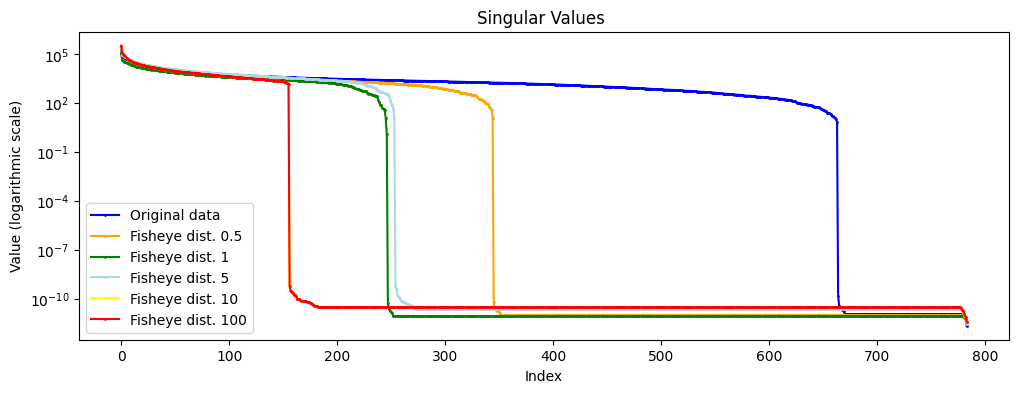

In [67]:
plt.figure(figsize=(12, 4))
plt.plot(E_orig, marker='o', color="blue", markersize=1, label="Original data")
plt.plot(E_fish_0_5, marker='o', color='orange', markersize=1, label="Fisheye dist. 0.5")
plt.plot(E_fish_1, marker='o', color='green', markersize=1, label="Fisheye dist. 1")
plt.plot(E_fish_5, marker='o', color='lightblue', markersize=1, label="Fisheye dist. 5")
plt.plot(E_fish_10, marker='o', color='yellow', markersize=1, label="Fisheye dist. 10")
plt.plot(E_fish_100, marker='o', color='red', markersize=1, label="Fisheye dist. 100")
plt.title("Singular Values ")
plt.xlabel("Index")
plt.ylabel("Value (logarithmic scale)")
plt.yscale("log")
plt.legend()
plt.show()


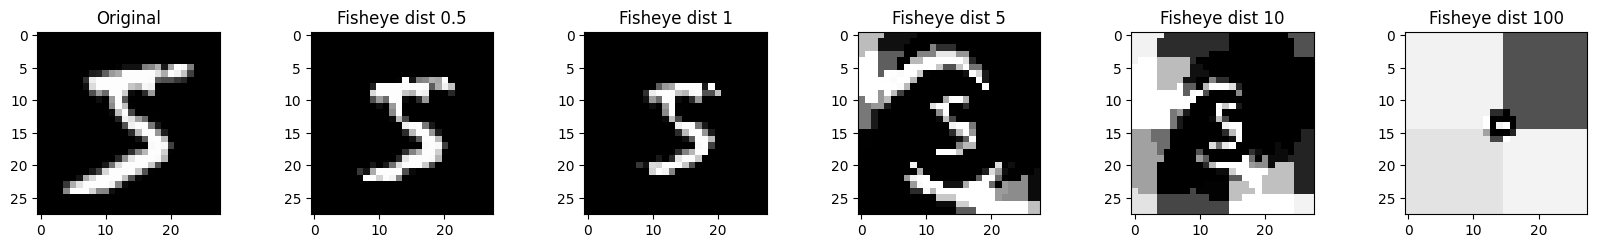

In [68]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 6, 1)
plt.imshow(images[0], cmap='gray')
plt.title('Original')

plt.subplot(1, 6, 2)
plt.imshow(fisheye_0_5[0], cmap='gray')
plt.title('Fisheye dist 0.5')

plt.subplot(1, 6, 3)
plt.imshow(fisheye_1[0], cmap='gray')
plt.title('Fisheye dist 1')

plt.subplot(1, 6, 4)
plt.imshow(fisheye_5[0], cmap='gray')
plt.title('Fisheye dist 5')

plt.subplot(1, 6, 5)
plt.imshow(fisheye_10[0], cmap='gray')
plt.title('Fisheye dist 10')
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 6, 6)
plt.imshow(fisheye_100[0], cmap='gray')
plt.title('Fisheye dist 100')
plt.subplots_adjust(wspace=0.5)

In [69]:
# reverse fisheye

fisheye_0_5_r = perform_fisheye_transform(images, -0.5)
flattened_fisheye_0_5_r = fisheye_0_5_r.reshape(fisheye_0_5_r.shape[0], -1)

fisheye_1_r = perform_fisheye_transform(images, -1)
flattened_fisheye_1_r = fisheye_1_r.reshape(fisheye_1_r.shape[0], -1)

fisheye_5_r = perform_fisheye_transform(images, -5)
flattened_fisheye_5_r = fisheye_5_r.reshape(fisheye_5_r.shape[0], -1)

fisheye_10_r = perform_fisheye_transform(images, -10)
flattened_fisheye_10_r = fisheye_10_r.reshape(fisheye_10_r.shape[0], -1)

fisheye_100_r = perform_fisheye_transform(images, -100)
flattened_fisheye_100_r = fisheye_10_r.reshape(fisheye_100_r.shape[0], -1)


In [73]:
U_fish_0_5_r, E_fish_0_5_r, V_t_fish_0_5_r = np.linalg.svd(flattened_fisheye_0_5_r, full_matrices=False)
U_fish_1_r, E_fish_1_r, V_t_fish_1_r = np.linalg.svd(flattened_fisheye_1_r, full_matrices=False)
U_fish_5_r, E_fish_5_r, V_t_fish_2_r = np.linalg.svd(flattened_fisheye_5_r, full_matrices=False)
U_fish_10_r, E_fish_10_r, V_t_fish_10_r = np.linalg.svd(flattened_fisheye_10_r, full_matrices=False)
U_fish_100_r, E_fish_100_r, V_t_fish_100_r = np.linalg.svd(flattened_fisheye_100_r, full_matrices=False)

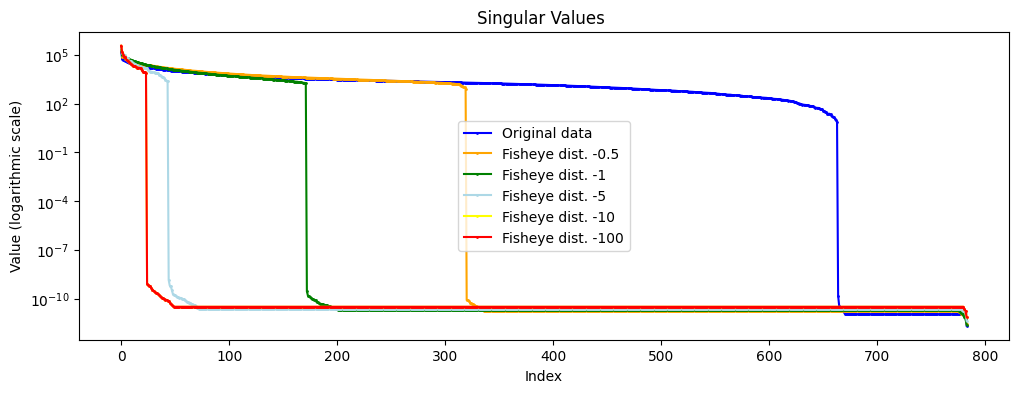

In [71]:
plt.figure(figsize=(12, 4))
plt.plot(E_orig, marker='o', color="blue", markersize=1, label="Original data")
plt.plot(E_fish_0_5_r, marker='o', color='orange', markersize=1, label="Fisheye dist. -0.5")
plt.plot(E_fish_1_r, marker='o', color='green', markersize=1, label="Fisheye dist. -1")
plt.plot(E_fish_5_r, marker='o', color='lightblue', markersize=1, label="Fisheye dist. -5")
plt.plot(E_fish_10_r, marker='o', color='yellow', markersize=1, label="Fisheye dist. -10")
plt.plot(E_fish_100_r, marker='o', color='red', markersize=1, label="Fisheye dist. -100")
plt.title("Singular Values ")
plt.xlabel("Index")
plt.ylabel("Value (logarithmic scale)")
plt.yscale("log")
plt.legend()
plt.show()

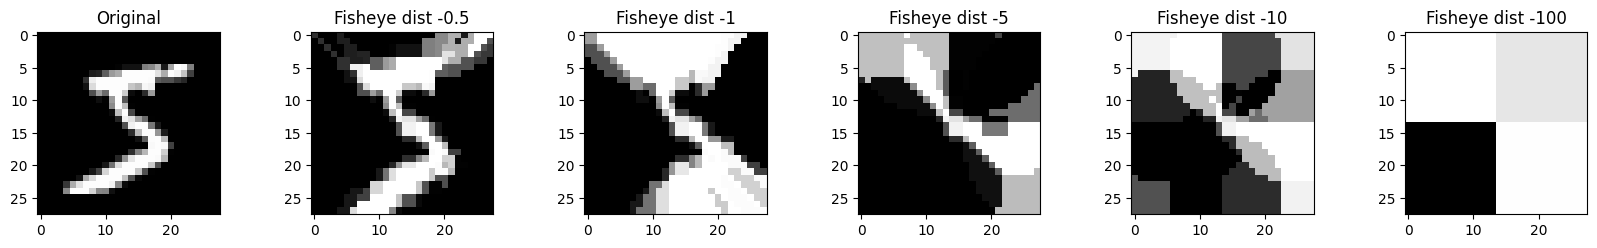

In [72]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 6, 1)
plt.imshow(images[0], cmap='gray')
plt.title('Original')

plt.subplot(1, 6, 2)
plt.imshow(fisheye_0_5_r[0], cmap='gray')
plt.title('Fisheye dist -0.5')

plt.subplot(1, 6, 3)
plt.imshow(fisheye_1_r[0], cmap='gray')
plt.title('Fisheye dist -1')

plt.subplot(1, 6, 4)
plt.imshow(fisheye_5_r[0], cmap='gray')
plt.title('Fisheye dist -5')

plt.subplot(1, 6, 5)
plt.imshow(fisheye_10_r[0], cmap='gray')
plt.title('Fisheye dist -10')

plt.subplot(1, 6, 6)
plt.imshow(fisheye_100_r[0], cmap='gray')
plt.title('Fisheye dist -100')

plt.subplots_adjust(wspace=0.5)

In [101]:
# reconstruct using k singular values
def reconstruct(U, E, V_t, k_values, distortion):
    U_k = U[:, :k_values]
    E_k = np.diag(E[:k_values])
    V_k = V_t[:k_values, :]

    k_reduced = np.dot(U_k, np.dot(E_k, V_k))

    if distortion == 0:
        return k_reduced

    # invert back to original if distorted
    return perform_fisheye_transform(k_reduced, -distortion)
